In [2]:
source("load_matrix.R")
# We have the sce object, scater, and singlecellexperiment

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsp

# Filtering (Cell QC)

## Strategies

### There are two approaches:
  1. Filter based on individual gene transcript counts within each cell 
  OR
  2. Filter based on total transcripts discovered in a cell.
  
### Contending Issues
  * Different cells were loaded across two different plates
  * Different cells might have different systematic variations that could give false signal.


### Approaches
  1. If we filter based on (1), then we remove any lowly expressed genes, but ignore any cell-to-cell bias that may exist
  OR
  2. If we filter based on (2), then we assess the quality of each cell as a whole first before determining whether a gene is suitable for analysis or not.

### Summary

 * Filtering on 2 makes the most sense, since a low quality cell is more likely to exhibit a lower UMI counts in general, and may confound the analysis by creating variation only by course of being unhealthy, and NOT informative towards biological signal.
 
 * Indeed, in the hemberg-lab workflow -- we can see that they filter for cells first, and then genes.


## How to assess cell quality

 1. Kick out any cells with a total column sum less than 25000.
 
 This is the approach taken by the hemberg team, however they work with higher sequencing depth. 
 
 ![title](https://hemberg-lab.github.io/scRNA.seq.course/07-exprs-qc_files/figure-html/total-counts-hist-1.png)
 
 However, our data has much lower coverage:

[1] 62

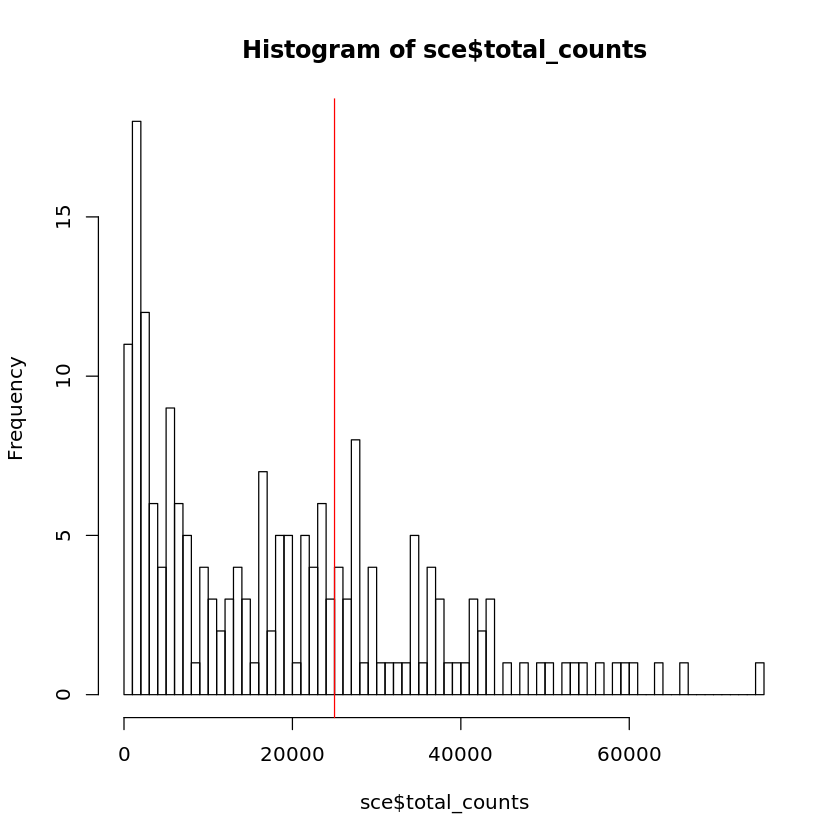

In [43]:
hist(sce$total_counts, breaks = 100)
abline(v = 25000, col = "red")

cells_filtered_hem <- dim(sce[,colSums(counts(sce)) > 25000])[[2]]
cells_filtered_hem

     so if we were to to cut out cells by this much we would risk having only 62 cells and losing more than 50% of our data.
     
     A better idea might be to set the limit to some lower threshold. 
     
     Let us explore how many cells we lose if we vary this threshold.

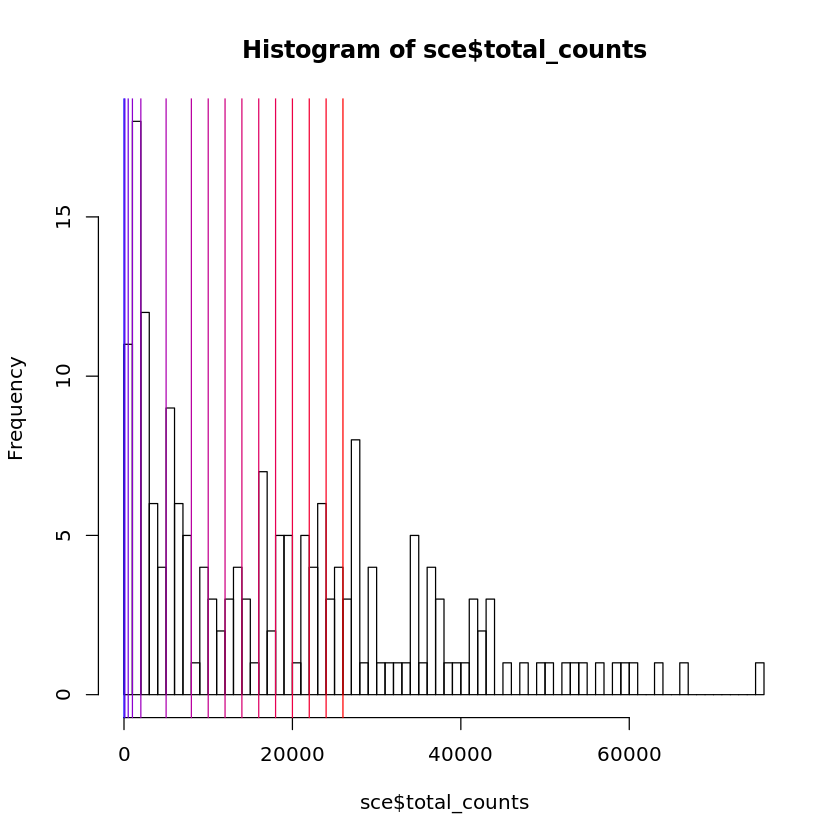

In [185]:
hist(sce$total_counts, breaks = 100)

table <- data.frame()
ranges_c <- append(c(1,100,500,1000,2000, 5000), seq(8000,26000,2000))
colors_c <- scales::seq_gradient_pal("blue", "red", "Lab")(seq(0,1,length.out=length(ranges_c)))


feature_table <- data.frame()

it = 0
for (thresh in ranges_c){
    it = it + 1    
    new_sce <- sce[,colSums(counts(sce)) > thresh]
    
    cells_left <- dim(new_sce)[[2]]    
    
    table <- rbind(table, c(thresh, 100 * cells_left / dim(sce)[[2]]))    
    feature_table <- rbind(feature_table, cbind( c(thresh), new_sce$total_features))
    
    abline(v=thresh, col=colors_c[[it]])
}

names(table) <- c("SeqThreshold", "CellsLeft")
names(feature_table) <- c("SeqThreshold", "AllExprValues")

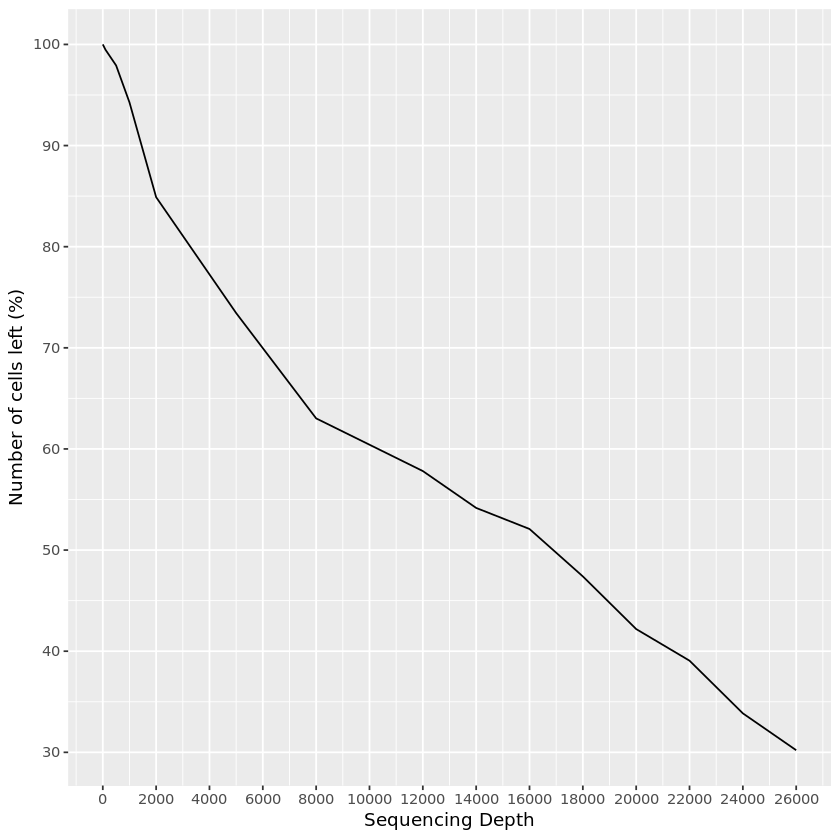

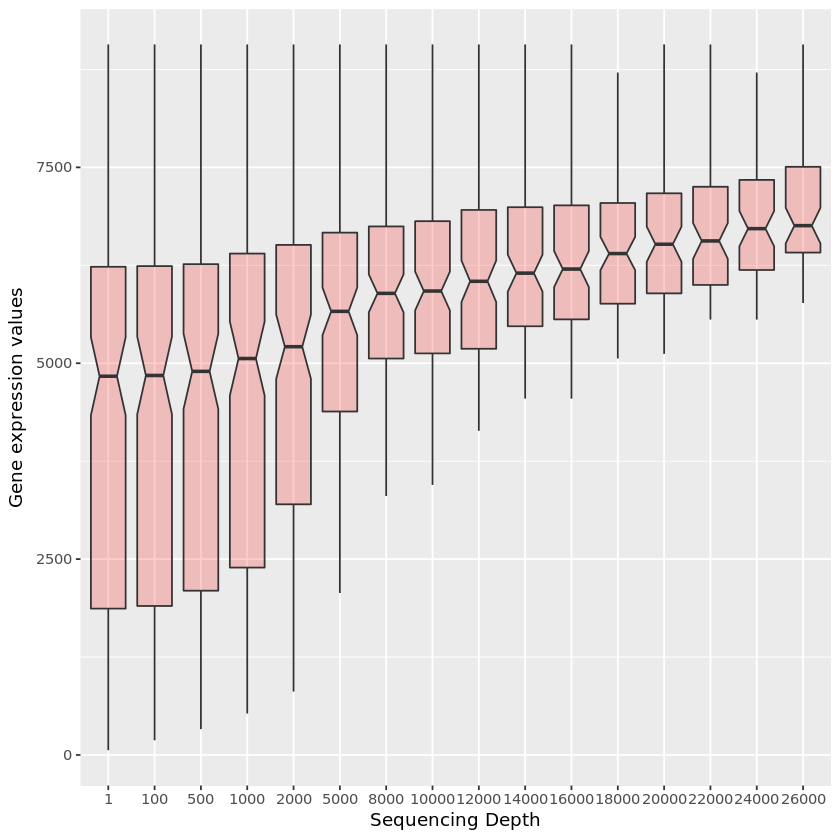

In [186]:
ggplot(table, aes(x=SeqThreshold, y=CellsLeft)) + geom_line(
) + xlab("Sequencing Depth"
) + ylab("Number of cells left (%)"
) + scale_x_continuous(breaks = seq(0, max(table$SeqThreshold), 2000)
) + scale_y_continuous(breaks = seq(0,100,10))

ggplot(feature_table, aes(x = factor(SeqThreshold), y = AllExprValues, group =SeqThreshold)
) + geom_boxplot(notch=T, outlier.shape = NA, fill = "red", alpha = 0.2,
) + xlab("Sequencing Depth"
) + ylab("Gene expression values"
) 

        From this we can see that the variation in our global expression levels becomes less tail-heavy at a sequencing depth of >= 6000. At this level, we can still retain 68% of our cells.
        
        From this we can see that if we filter for >= 6000 in any one cell, then we can still retain between 68% of our cells, whilst having a more
        
        One problem with this approach is that it assumes that the cells which 

SeqThreshold,AllExprValues
1,1569
1,6400
1,5206
1,3952
1,6055
1,7020


In [30]:
sce <- calculateQCMetrics(sce)

# We wish to remove cells that only express 2 or more genes
#dim(sce)

message(dim(sce)[[2]], " cells (raw)")

min_genes <- c(1,2,3,4,5,10,20,30)
min_seq <- append(c(1,10,20,50,70,80), seq(100,800,50), c(25000))

#outer(min_genes, min_seq, function(g,s){sum(colSums(counts(sce) >= s) >= g)})

table <- data.frame()

for (g in min_genes){
    for (s in min_seq){
        cells <- sum(colSums(counts(sce) >= s) >= g)
        table <- rbind(table, c(s, g, cells))      
        message(sprintf("%4.0f cells with >= %5.0f seq-depth and >= %3.0f genes", cells, s, g))
    }
}
colnames(table) <- c("seqdepth", "genes", "cells")

192 cells (raw)
 192 cells with >=     1 seq-depth and >=   1 genes
 191 cells with >=    10 seq-depth and >=   1 genes
 188 cells with >=    20 seq-depth and >=   1 genes
 181 cells with >=    50 seq-depth and >=   1 genes
 173 cells with >=    70 seq-depth and >=   1 genes
 169 cells with >=    80 seq-depth and >=   1 genes
 161 cells with >=   100 seq-depth and >=   1 genes
 145 cells with >=   150 seq-depth and >=   1 genes
 118 cells with >=   200 seq-depth and >=   1 genes
 101 cells with >=   250 seq-depth and >=   1 genes
  84 cells with >=   300 seq-depth and >=   1 genes
  66 cells with >=   350 seq-depth and >=   1 genes
  47 cells with >=   400 seq-depth and >=   1 genes
  31 cells with >=   450 seq-depth and >=   1 genes
  18 cells with >=   500 seq-depth and >=   1 genes
  10 cells with >=   550 seq-depth and >=   1 genes
   7 cells with >=   600 seq-depth and >=   1 genes
   5 cells with >=   650 seq-depth and >=   1 genes
   1 cells with >=   700 seq-depth and >=   1 ge

   0 cells with >=   350 seq-depth and >=  30 genes
   0 cells with >=   400 seq-depth and >=  30 genes
   0 cells with >=   450 seq-depth and >=  30 genes
   0 cells with >=   500 seq-depth and >=  30 genes
   0 cells with >=   550 seq-depth and >=  30 genes
   0 cells with >=   600 seq-depth and >=  30 genes
   0 cells with >=   650 seq-depth and >=  30 genes
   0 cells with >=   700 seq-depth and >=  30 genes
   0 cells with >=   750 seq-depth and >=  30 genes
   0 cells with >=   800 seq-depth and >=  30 genes


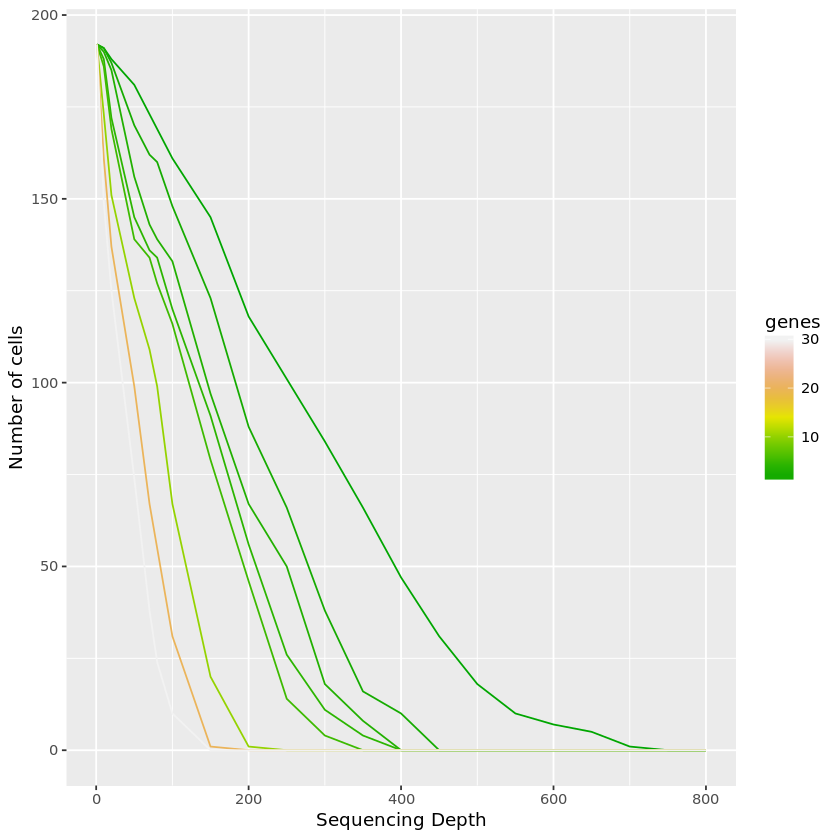

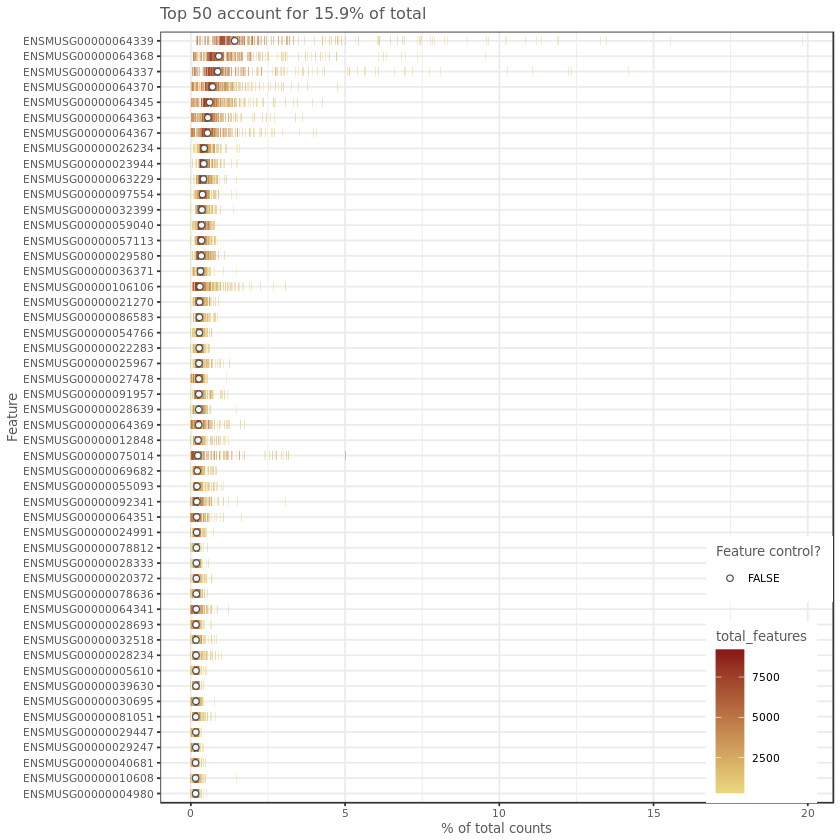

In [27]:
ggplot(table, aes(x=seqdepth, y=cells, group=genes)) + geom_line(
    aes(colour=genes)
) + scale_colour_gradientn(colours = terrain.colors(10)
                          ) + xlab("Sequencing Depth") + ylab("Number of cells")


plotQC(sce, type="high")

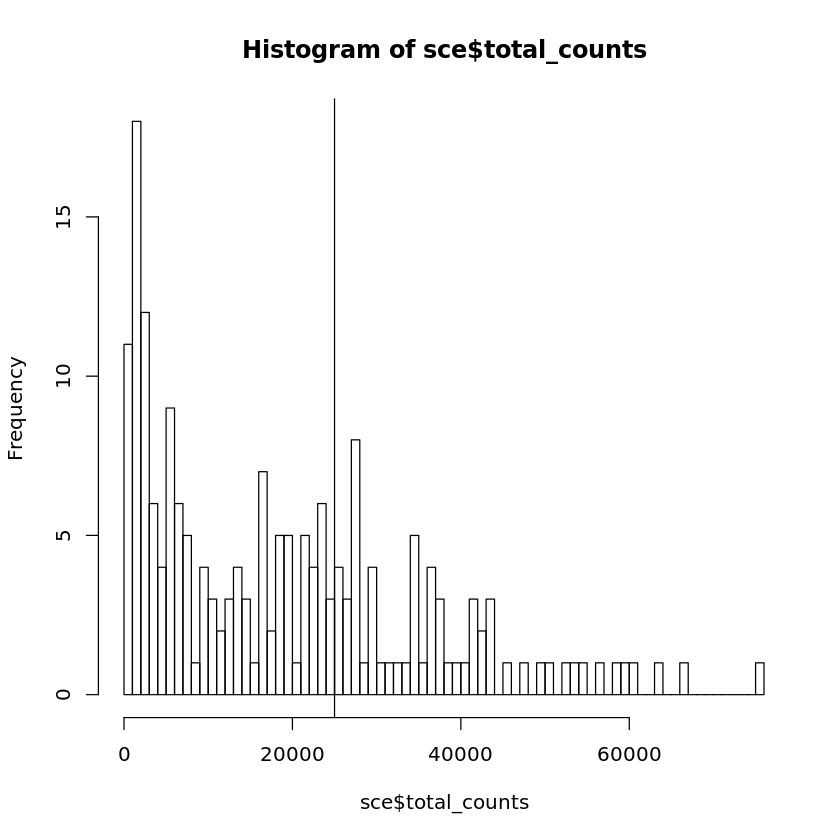

In [29]:
hist(
    sce$total_counts,
    breaks = 100
)
abline(v=25000)